In [1]:
import os
os.chdir("../")

In [2]:
os.getcwd()

'/home2/temiloluwa.adeoti/contrastive_ood_detection'

In [3]:
from pathlib import Path
from matplotlib import pyplot as plt
from imagereconstruction import ckpt_root, config, \
                attach_hook, freeze_encoder, Decoder, lr
from datasets.get_data import get_ensemble_eval_loaders
from torchvision import models
from utils import load_contrastive_model
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle

In [6]:
gpu = 2
gpu2 = 3
num_classes = 10
encoder = models.__dict__['resnet50'](num_classes=num_classes).cuda(gpu)
encoder = load_contrastive_model(ckpt_root, config, 128, encoder)
encoder = attach_hook(encoder)
encoder = freeze_encoder(encoder)

layer_4_output = False

class AutoEncoder(nn.Module):
    def __init__(self, skip_connect, layer_4_output, gpu):
        super().__init__()
        self.encoder = encoder
        self.decoder = Decoder(skip_connect, layer_4_output).cuda(gpu)
        self.layer_4_output = layer_4_output 

    def forward(self, x, decoder_input=False):
        if not decoder_input:
            self.encoder(x)
            features = [self.encoder.output3, self.encoder.output2, self.encoder.output1]
            if layer_4_output:
                o = self.encoder.output4
            else:
                x = self.encoder.avg_outputs
                features = [self.encoder.output4] + features
        else:
            if not self.decoder.skip_connect:
                features = []
            else:
                raise NotImplementedError

        o = self.decoder(x, features)

        return o


batch_size = 32
model = AutoEncoder(skip_connect = False, gpu=gpu, layer_4_output = layer_4_output)
model2 = AutoEncoder(skip_connect = True, gpu=gpu2, layer_4_output = layer_4_output)
optimizer = torch.optim.SGD(model.parameters(), lr)
criterion = nn.MSELoss().cuda(gpu)

train_loader, test_loader = get_ensemble_eval_loaders("CIFAR10", "CIFAR10", batch_size)

loaded contrastive model @ ckpt: /data/temiloluwa.adeoti/third_experiments/CIFAR10_clus_2816_neg_2560/exp_0/checkpoints/checkpoint_0199.pth.tar
Outputing contrastive model from Avgpool Layer
param conv1.weight frozen
param bn1.weight frozen
param bn1.bias frozen
param layer1.0.conv1.weight frozen
param layer1.0.bn1.weight frozen
param layer1.0.bn1.bias frozen
param layer1.0.conv2.weight frozen
param layer1.0.bn2.weight frozen
param layer1.0.bn2.bias frozen
param layer1.0.conv3.weight frozen
param layer1.0.bn3.weight frozen
param layer1.0.bn3.bias frozen
param layer1.0.downsample.0.weight frozen
param layer1.0.downsample.1.weight frozen
param layer1.0.downsample.1.bias frozen
param layer1.1.conv1.weight frozen
param layer1.1.bn1.weight frozen
param layer1.1.bn1.bias frozen
param layer1.1.conv2.weight frozen
param layer1.1.bn2.weight frozen
param layer1.1.bn2.bias frozen
param layer1.1.conv3.weight frozen
param layer1.1.bn3.weight frozen
param layer1.1.bn3.bias frozen
param layer1.2.conv

In [106]:
ckpt_path = f"./cache/no_skip_connect_no_layer_4_output_2_visual_model.pth.tar"
ckpt_path2 = f"./cache/skip_connect_no_layer_4_output_visual_model.pth.tar"
checkpoint = torch.load(ckpt_path, map_location=f"cuda:{gpu}")
model.load_state_dict(checkpoint['state_dict'])
checkpoint = torch.load(ckpt_path2, map_location=f"cuda:{gpu2}")
model2.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [7]:
eval_data = next(iter(test_loader))

In [9]:
from functools import partial
_mean=np.array([0.491, 0.482, 0.447]).reshape([1, 3, 1, 1])
_std=np.array([0.247, 0.243, 0.262]).reshape([1, 3, 1, 1])

def un_normalize(x, mean, std):
    if x.ndim == 3:
        mean = mean[0]
        std = std[0]
        
    x = x * std + mean
    return (x - x.min())/(x.max() - x.min())

un_normalize = partial(un_normalize, mean=_mean, std=_std)


In [10]:
model.cuda(gpu)
model.eval()
model2.cuda(gpu2)
model2.eval()
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [11]:
def compute_features(model, gpu):
    train_imgs = []
    train_avg_features = []
    train_gt_targets = []
    model.cuda(gpu)
    for img, targ in tqdm(train_loader):
        _ = model(img.cuda(gpu))
        train_imgs.append(img)
        output = model.encoder.avg_outputs.detach().cpu().numpy()
        train_avg_features.append(output)
        train_gt_targets.append(targ.detach().cpu().numpy().reshape(-1, 1))

    train_imgs = torch.vstack(train_imgs)
    train_avg_features = np.vstack(train_avg_features)
    train_gt_targets = np.vstack(train_gt_targets)
    return train_imgs, train_avg_features, train_gt_targets

In [12]:
train_imgs, train_avg_features, train_gt_targets = compute_features(model, gpu)
print(f"train_feats {train_avg_features.shape}, train_targs {train_gt_targets.shape}")

  0%|          | 1/1563 [00:00<21:30,  1.21it/s]

Using Avgpool as Decoder Input
No Skip Connect


100%|██████████| 1563/1563 [01:35<00:00, 16.32it/s]


train_feats (50000, 2048, 1, 1), train_targs (50000, 1)


In [13]:
perform_clustering = False
im2cluster_fn = './cache/im2cluster.pickle'
x = train_avg_features
num_cluster = 2560
seed = 3

In [103]:
def save_pickle(file, fn):
    with open(fn, 'wb') as f:
        pickle.dump(file, f, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
import faiss

if perform_clustering:
    d = x.shape[1]
    k = int(num_cluster)
    clus = faiss.Clustering(d, k)
    clus.verbose = True
    clus.niter = 20
    clus.nredo = 5
    clus.seed = seed
    clus.max_points_per_centroid = 1000
    clus.min_points_per_centroid = 10

    index = faiss.IndexFlatL2(d)   
    clus.train(x, index)   

    D, I = index.search(x, 1) # for each sample, find cluster distance and assignments
    im2cluster = [int(n[0]) for n in I]
    with open(im2cluster_fn, 'wb') as f:
        pickle.dump(im2cluster, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
train_avg_features

In [15]:
if os.path.exists(im2cluster_fn):
    with open(im2cluster_fn, 'rb') as f:
        im2cluster = pickle.load(f)

In [16]:
gt_per_clus = [[] for i in range(num_cluster)]
for i, clus in enumerate(im2cluster):
    gt_per_clus[clus].append(int(train_gt_targets[i]))
    

In [87]:
def forward(inp, model, gpu):
    model.cuda(gpu)
    inp = inp.cuda(gpu)
    out = model(inp)
    return out

In [88]:
from collections import Counter, OrderedDict
#cluster nums = 45, 58, 102, 200, 203
im2cluster = np.array(im2cluster)
#target = targ.detach().cpu().numpy()

In [140]:
from PIL import Image
import os

_args = [(model, gpu, "no_skip_connect"), (model2, gpu2, "skip_connect")]


def combo_images(imgs_fns, clus_num):
    images = [Image.open(x) for x in imgs_fns]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save(f'cluster_{clus_num}.jpg')
    for fn in imgs_fn:
        os.remove(fn)
    
def plot_model(clus_num, _args=_args):
    clus_idx = np.where(im2cluster==clus_num)[0]
    imgs_fns = []
    for model, gpu, _type in _args:   
        imgs = train_imgs[clus_idx]
        num_imgs = len(gt_per_clus[clus_num])
        ncols = 4
        nrows = num_imgs // ncols
        max_num_imgs = len(imgs)
        
        out = forward(imgs, model, gpu)
        out = un_normalize(out.detach().cpu().numpy())
        print(f"inp {imgs.shape}, out {out.shape}")
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
        fig.set_figheight(20)
        fig.set_figwidth(20)
        i = 1
        fig.suptitle(f"{_type}")
        for row in ax:
            for col in row:
                col.set_xticks([])
                col.set_yticks([])
                if i == max_num_imgs:
                    break
                col.imshow(out[i].transpose(1,2,0))
                col.set_title(f"gt class: {classes[int(train_gt_targets[clus_idx][i])]}")
                i += 1
        fn = f'cache/cluster_{_type}_{clus_num}.jpg'
        imgs_fns.append(fn)
        fig.savefig(fn)
    combo_images(imgs_fns, clus_num)

In [ ]:
clus_num = 200
plot_model(clus_num)

inp torch.Size([24, 3, 224, 224]), out (24, 3, 224, 224)
inp torch.Size([24, 3, 224, 224]), out (24, 3, 224, 224)


NameError: name 'imgs_fn' is not defined

## visualize codes

In [105]:
save_pickle(train_avg_features, "./cache/train_avg_features.pkl")
save_pickle(gt_per_clus, "./cache/gt_per_clus.pkl")

In [107]:
clus_num = 200
clus_idx = np.where(im2cluster==clus_num)[0]
clus_idx

array([ 1617,  2487,  2934,  3753,  4743,  5648,  7737, 12251, 13425,
       14991, 20100, 24376, 24990, 26038, 27310, 28841, 29477, 38371,
       41447, 41773, 44442, 44659, 44690, 46499])

In [108]:
clus_avg_pool_feats = train_avg_features[clus_idx]
clus_avg_pool_feats = torch.from_numpy(clus_avg_pool_feats).to(gpu)
clus_avg_pool_feats.shape

torch.Size([24, 2048, 1, 1])

In [109]:
clus_output = model(clus_avg_pool_feats, decoder_input=True)
clus_output = un_normalize(clus_output.detach().cpu().numpy())
clus_output.shape

(24, 3, 224, 224)

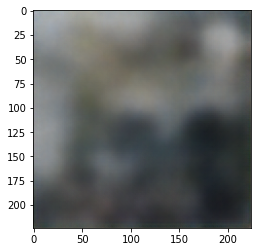

In [113]:
i = 4
plt.imshow(clus_output[i].transpose(1,2,0))

In [73]:
clus_output2 = model(train_imgs[clus_idx].cuda(gpu), decoder_input=False)
clus_output2 = un_normalize(clus_output2.detach().cpu().numpy())
clus_output2.shape

(31, 3, 224, 224)

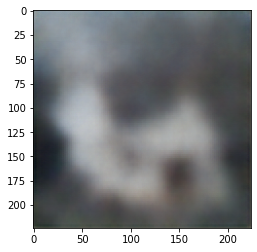

In [74]:
i = 2
plt.imshow(clus_output2[i].transpose(1,2,0))

In [ ]:
count_per_clus = OrderedDict(sorted(Counter(im2cluster).items()))

In [ ]:
majority_percent_per_clus = []
majority_class = []
pure_clusters = []
impure_clusters = []

for i,v in enumerate(gt_per_clus):
    total_count = len(v)
    major_class, majority_count = Counter(v).most_common()[0]
    majority_class.append(classes[major_class])
    majority_percent = majority_count/total_count * 100
    if majority_percent == 100.0:
        pure_clusters.append(classes[major_class])
    else:
        impure_clusters.append((classes[major_class], majority_percent))
    majority_percent_per_clus.append(majority_percent)

In [ ]:
count_per_major_class = Counter(majority_class)
count_p_keys, count_p_values = zip(*OrderedDict(sorted(count_per_major_class.items())).items())
fig = plt.figure(figsize=(10,6))
y_pos = np.arange(len(count_p_keys))
plt.bar(y_pos, count_p_values)
plt.xticks(y_pos, count_p_keys)
plt.ylabel('Count')
plt.title('Cluster Count per Class')
fig.savefig(f'cache/Cluster_count_per_class.jpg')

In [ ]:
c_pure_clusters = Counter(pure_clusters)
c_pure_clusters = {k: v/count_per_major_class[k]*100 for k, v in c_pure_clusters.items()}
pc_keys, pc_values = zip(*OrderedDict(sorted(c_pure_clusters.items())).items())
fig = plt.figure(figsize=(10,6))
y_pos = np.arange(len(pc_keys))
plt.bar(y_pos, pc_values)
plt.xticks(y_pos, pc_keys)
plt.ylabel('Percent')
plt.title('Percentage of each Class that have Pure Clusters')
fig.savefig(f'cache/pure_clusters.jpg')

In [ ]:
impure_clus_df = pd.DataFrame(impure_clusters).rename(columns={0:"class", 1:"purity"})
c_impure_clusters = Counter(impure_clus_df[impure_clus_df.purity < 50]["class"])
c_impure_clusters = {k: v/count_per_major_class[k]*100 for k, v in c_impure_clusters.items()}
ipc_keys, ipc_values = zip(*OrderedDict(sorted(c_impure_clusters.items())).items())
fig = plt.figure(figsize=(10,6))
y_pos = np.arange(len(pc_keys))
plt.bar(y_pos, ipc_values)
plt.xticks(y_pos, ipc_keys)
plt.ylabel('Percent')
plt.title('Percentage of each Class with Clusters of Purity less than 50%')
fig.savefig(f'cache/impure_50_clusters.jpg')

In [ ]:
impure_clus_df = pd.DataFrame(impure_clusters).rename(columns={0:"class", 1:"purity"})
c_impure_clusters = Counter(impure_clus_df[impure_clus_df.purity >= 50]["class"])
c_impure_clusters = {k: v/count_per_major_class[k]*100 for k, v in c_impure_clusters.items()}
ipc_keys, ipc_values = zip(*OrderedDict(sorted(c_impure_clusters.items())).items())
fig = plt.figure(figsize=(10,6))
y_pos = np.arange(len(pc_keys))
plt.bar(y_pos, ipc_values)
plt.xticks(y_pos, ipc_keys)
plt.ylabel('Percent')
plt.title('Percentage of each Class with Clusters of Purity between 50% and 99.99%')
fig.savefig(f'cache/impure_above50_clusters.jpg')